# The Capital Asset Pricing Model (CAPM)
#### By Chris Preuss


CAPM remains one of the workhorse statistical models in finance. It is so common that sites like Yahoo!Finance report the measures we will estimate statistically.

I use CAPM for a reason: absent experimental data, it is the only application of the bivariate linear model that I believe has validity in the real world.

The upshot of the CAPM says that we can directly interpret the intercept and slope coefficients as real-world measures relating the excess (or risk-adjusted) returns of a particular stock to those of a basket of stocks, such as a specific market.

## CAPM as a Bivariate Linear Model

Let ri denote the rate of return to asset i, rf denote the known rate of return on a risk-free asset (for example, short-term US government debt), and rm denote the rate of return to a portfolio (or a market) that includes i.
The following equation can be derived:

E(ri)−rf= α+β⋅(E(rm)−rf)

Here, E(⋅) denotes an expected value (because this is a forward-looking prediction). In CAPM, β captures the sensitivity of an asset’s returns to the returns to a portfolio or to the market on which an asset trades. In other words, it non-diversifiable risk. In addition, α measures an asset i’s excess (or abnormal) returns.

Phrases you may have heard:

    1. The stock's beta is high
    2. The hedge fund is chasing alpha

Formally, we can express our conjecture as a joint hypothesis:

H0:α=0,β=1
H1: not H0

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.data as web
import quandl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import patsy
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)


In [135]:
# Grab 10 years of Apple and NASDAQ data using Quandl.  You can also you pandas.io.data to grab from sites like Yahoo!Finance.
# Apple trades internationally on the NASDAQ OMX.  

aapl_all = quandl.get("YAHOO/AAPL", trim_start="2005-1-1")
nasdaq_all = quandl.get("NASDAQOMX/COMP", trim_start="2005-1-1")
aapl = aapl_all['Adjusted Close']
nasdaq = nasdaq_all['Index Value']

In [136]:
aapl_all.head()
#aapl.head()

,Open,High,Low,Close,Volume,Adjusted Close
Date,,,,,,
2005-01-03,64.780001,65.110002,62.599998,63.290000,172998000.0,4.138829
2005-01-04,63.789998,65.470003,62.969999,63.940001,274202600.0,4.181335
2005-01-05,64.460000,65.249998,64.049997,64.500001,170108400.0,4.217956
2005-01-06,64.669998,64.909997,63.330001,64.550002,176388800.0,4.221226
2005-01-07,64.999999,69.629998,64.750000,69.250003,556862600.0,4.528581


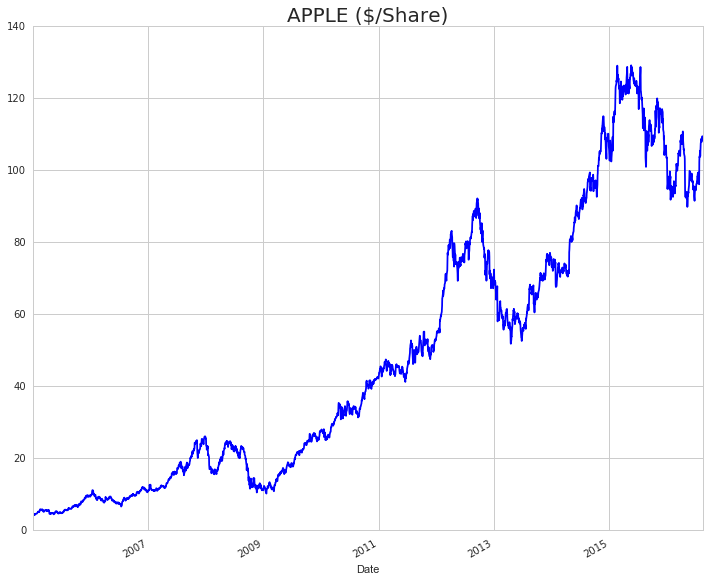

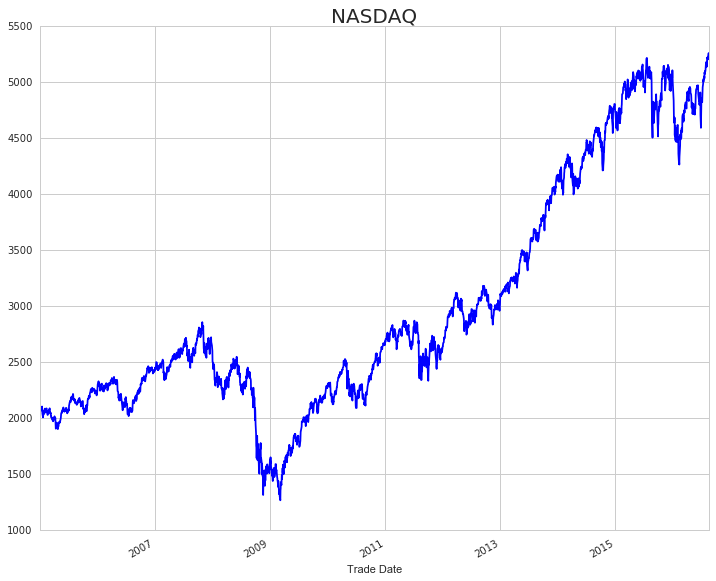

In [137]:
plt.figure(figsize = (12,10))

#plt.plot(aapl)
aapl.plot(color='blue')
plt.title('APPLE ($/Share)', fontsize=20)
plt.figure(figsize = (12,10))

#plt.plot(nasdaq)
nasdaq.plot(color='blue')
plt.title('NASDAQ', fontsize=20)

In [138]:
# For our purposes, let's limit to the last five years.

aapl_all = quandl.get("YAHOO/AAPL", trim_start="2010-1-1")
nasdaq_all = quandl.get("NASDAQOMX/COMP", trim_start="2010-1-1")
aapl = aapl_all['Adjusted Close']
nasdaq = nasdaq_all['Index Value']

# Calculate log returns, which is the standard finance measure for daily returns in finance.
aapl_returns = np.log(aapl / aapl.shift(1))
nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
aapl_returns = aapl_returns.dropna()
nasdaq_returns = nasdaq_returns.dropna()

print aapl_returns.mean(), aapl_returns.std()

0.0008165307512 0.01676101824


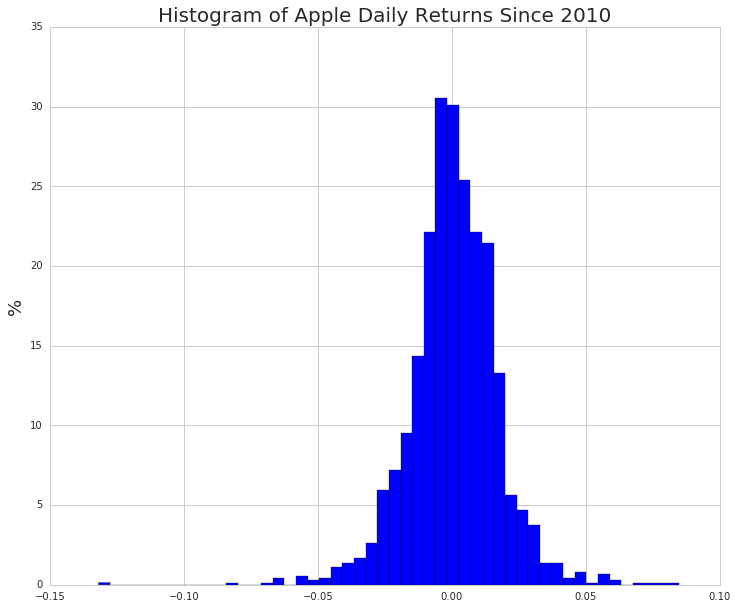

In [139]:
plt.figure(figsize= (12,10))
plt.hist(aapl_returns, bins=50, normed=True, color='blue')
plt.title('Histogram of Apple Daily Returns Since 2010', fontsize=20)
plt.ylabel('%', fontsize=18)

In [140]:
print nasdaq_returns.mean(), nasdaq_returns.std()

0.00049098201462 0.0111770385332


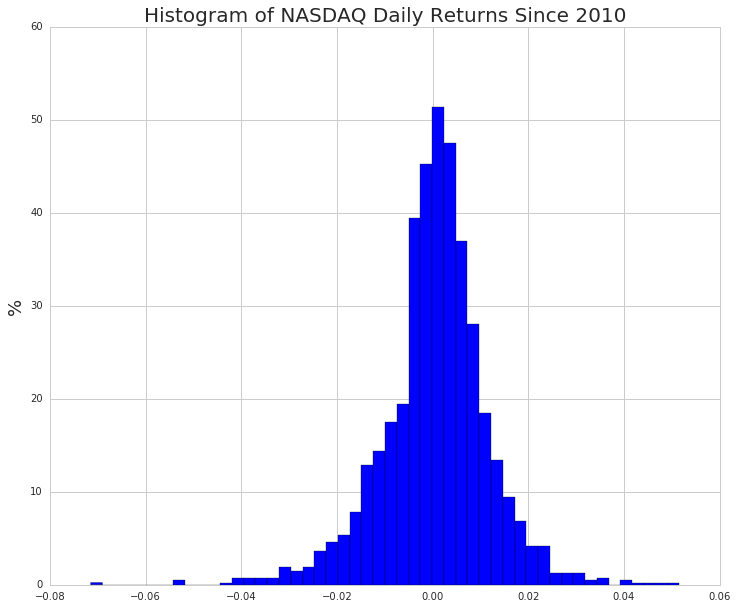

In [141]:
plt.figure(figsize= (12,10))
plt.hist(nasdaq_returns, bins=50, normed=True, color='blue')
plt.title('Histogram of NASDAQ Daily Returns Since 2010', fontsize=20)
plt.ylabel('%', fontsize=18)

In [142]:
# Create dataframes for merge and regression.
import pandas as pd
aapl_returns = pd.DataFrame(aapl_returns)
n_returns = pd.DataFrame(nasdaq_returns)


In [143]:
# Confirm dataframes
aapl_returns.info()
n_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1669 entries, 2010-01-05 to 2016-08-19
Data columns (total 1 columns):
Adjusted Close    1669 non-null float64
dtypes: float64(1)
memory usage: 26.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1669 entries, 2010-01-05 to 2016-08-19
Data columns (total 1 columns):
Index Value    1669 non-null float64
dtypes: float64(1)
memory usage: 26.1 KB


(-0.1, 0.1)

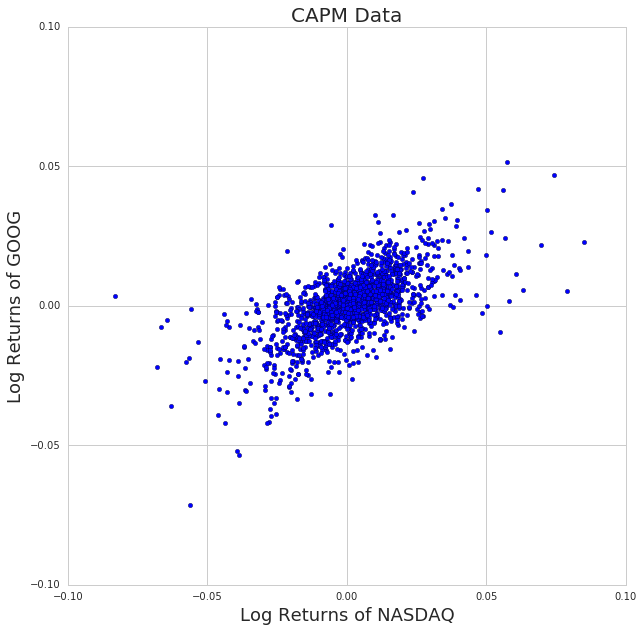

In [144]:

plt.figure(figsize = (10,10))
plt.scatter(aapl_returns, nasdaq_returns)
plt.title('CAPM Data', fontsize = 20)
plt.xlabel('Log Returns of NASDAQ', fontsize = 18)
plt.ylabel('Log Returns of GOOG', fontsize = 18)
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])

In [145]:
# Merge and rename.

data = pd.merge(n_returns, aapl_returns, left_index=True, right_index=True)
data.rename(columns={'Index Value':'nasdaq', 'Adjusted Close':'aapl'}, inplace=True)

In [146]:
# Confirm summary stats

print data.mean()
print data.std()

nasdaq    0.000491
aapl      0.000817
dtype: float64
nasdaq    0.011177
aapl      0.016761
dtype: float64


In [147]:
# Use StatsModels Formula, which emulates R formula style.
# Run CAPM and review results.
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     1143.
Date:                Sun, 21 Aug 2016   Prob (F-statistic):          3.32e-191
Time:                        09:29:47   Log-Likelihood:                 4892.0
No. Observations:                1669   AIC:                            -9780.
Df Residuals:                    1667   BIC:                            -9769.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      1.097      0.2

(-0.1, 0.1)

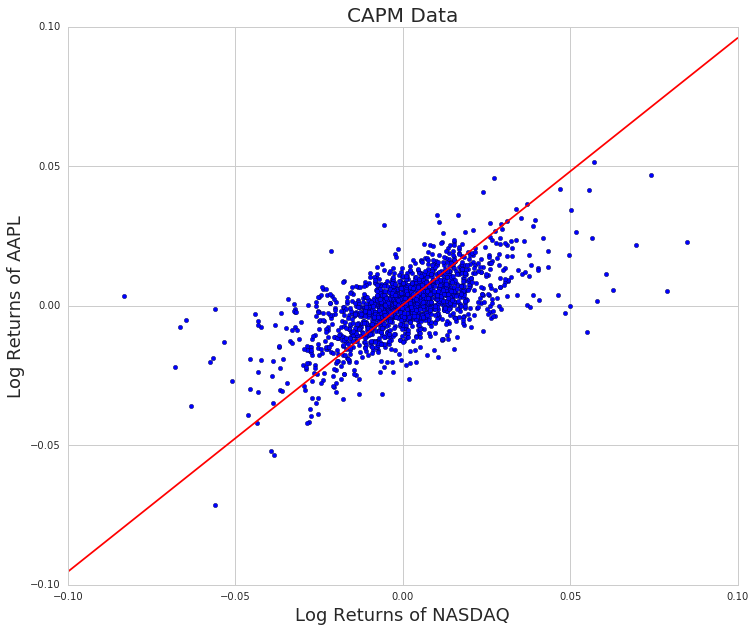

In [148]:
# This a convoluted

figure, ax = plt.subplots(figsize=(12,10))
ax.scatter(aapl_returns, nasdaq_returns)
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
abline_plot(model_results=mod, ax=ax, color='red')

ax.set_title('CAPM Data', fontsize = 20)
ax.set_ylabel('Log Returns of AAPL', fontsize = 18)
ax.set_xlabel('Log Returns of NASDAQ', fontsize = 18)
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])